In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

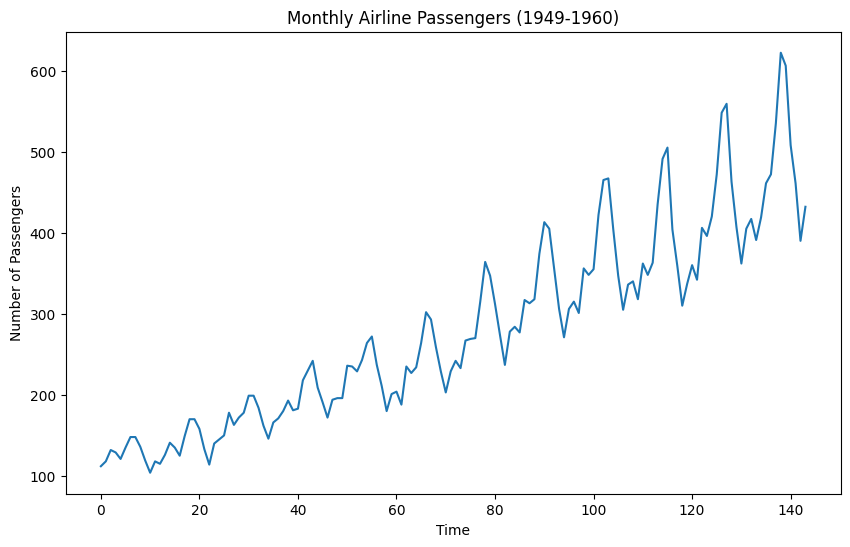

In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url)
passengers = data['Passengers'].values.astype(float)

plt.figure(figsize=(10, 6))
plt.plot(passengers)
plt.title("Monthly Airline Passengers (1949-1960)")
plt.xlabel("Time")
plt.ylabel("Number of Passengers")
plt.show()

In [3]:
passengers_diff = np.diff(passengers, n=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
passengers_normalized = scaler.fit_transform(passengers_diff.reshape(-1, 1))

def create_sequences(data, seq_length=12):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)

seq_length = 12
X, y = create_sequences(passengers_normalized, seq_length)

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

<ipython-input-3-d2ee5914af5b>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)


##  Baseline LSTM Model

Epoch [50/200], Loss: 0.0347
Epoch [100/200], Loss: 0.0107
Epoch [150/200], Loss: 0.0092
Epoch [200/200], Loss: 0.0072


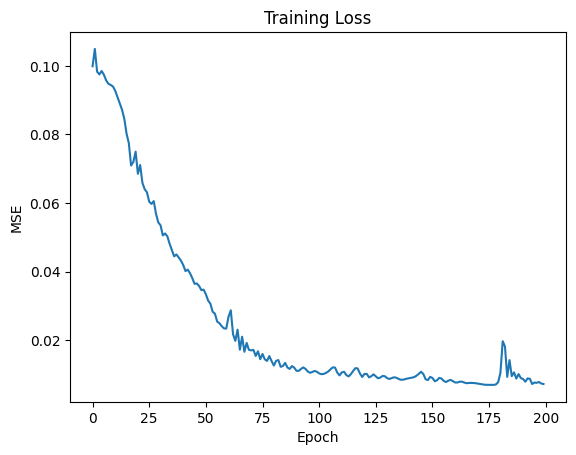

In [4]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.linear(out)
        return out

model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 200
train_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()



In [5]:
model.eval()
with torch.no_grad():
    test_preds = model(X_test)
    test_loss = criterion(test_preds, y_test)
    print(f"Test Loss (MSE): {test_loss.item():.4f}")

Test Loss (MSE): 0.0821


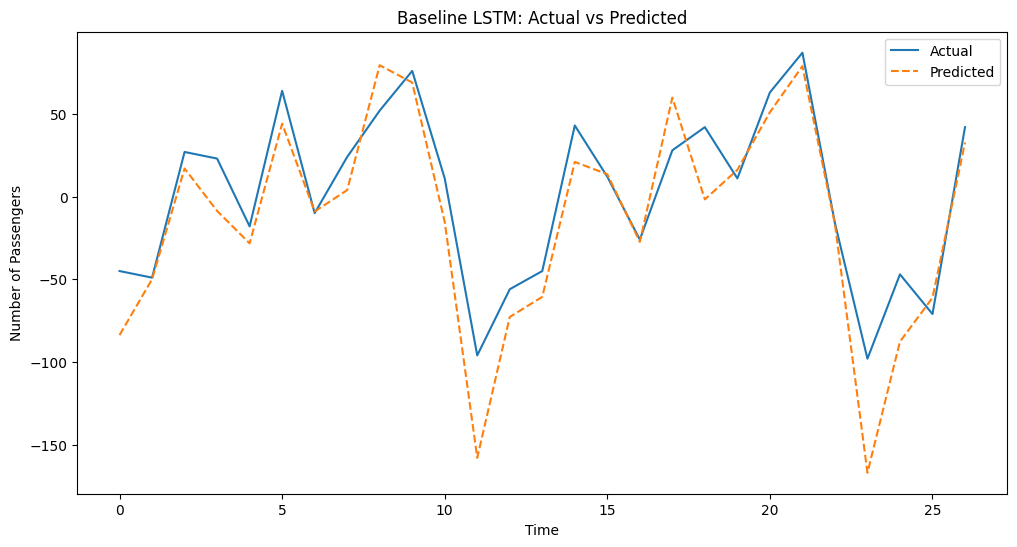

In [6]:
test_preds_actual = scaler.inverse_transform(test_preds.numpy())
y_test_actual = scaler.inverse_transform(y_test.numpy())

results = {}
results["Baseline LSTM"] = {
    "train_losses": train_losses.copy(),
    "test_loss": test_loss.item(),
    "predictions": test_preds_actual.copy(),
}

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(test_preds_actual, label='Predicted', linestyle='--')
plt.title("Baseline LSTM: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()

## Experiment with Larger Hidden Size

Epoch [50/200], Loss: 0.0369
Epoch [100/200], Loss: 0.0112
Epoch [150/200], Loss: 0.0046
Epoch [200/200], Loss: 0.0035


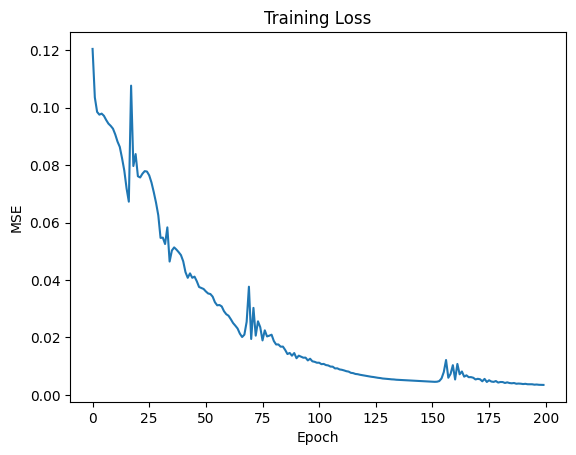

In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.linear(out)
        return out

model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 200
train_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

In [8]:
model.eval()
with torch.no_grad():
    test_preds = model(X_test)
    test_loss = criterion(test_preds, y_test)
    print(f"Test Loss (MSE): {test_loss.item():.4f}")

Test Loss (MSE): 0.0319


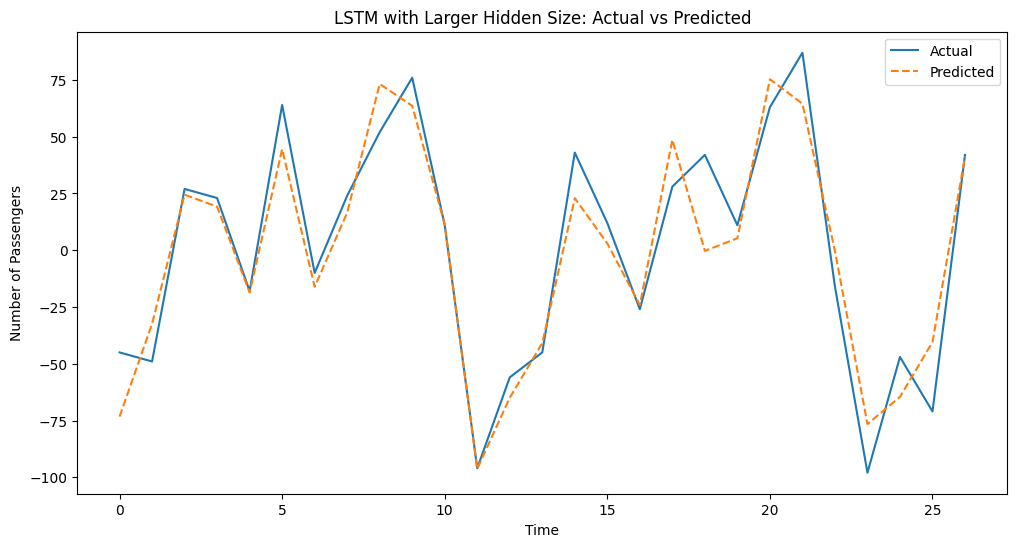

In [9]:
test_preds_actual = scaler.inverse_transform(test_preds.numpy())
y_test_actual = scaler.inverse_transform(y_test.numpy())

results["LSTM with Larger Hidden Size"] = {
    "train_losses": train_losses.copy(),
    "test_loss": test_loss.item(),
    "predictions": test_preds_actual.copy(),
}

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(test_preds_actual, label='Predicted', linestyle='--')
plt.title("LSTM with Larger Hidden Size: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()

## Final Model with Dropout and Early Stopping

Epoch [50/300], Train Loss: 0.0354, Val Loss: 0.0776
Early stopping at epoch 94


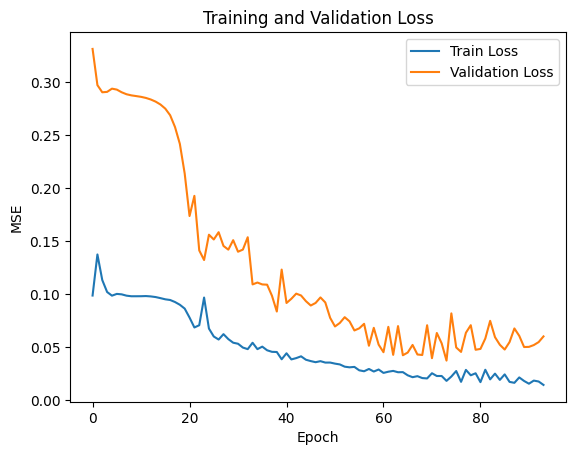

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.linear(out)
        return out

model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

epochs = 300
train_losses = []
val_losses = []
best_loss = float('inf')
patience = 20
trigger_times = 0

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        val_losses.append(val_loss.item())

    scheduler.step(val_loss)

    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    if val_loss < best_loss:
        best_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()



In [11]:
model.eval()
with torch.no_grad():
    test_preds = model(X_test)
    test_loss = criterion(test_preds, y_test)
    print(f"Final Test Loss (MSE): {test_loss.item():.4f}")

Final Test Loss (MSE): 0.0601


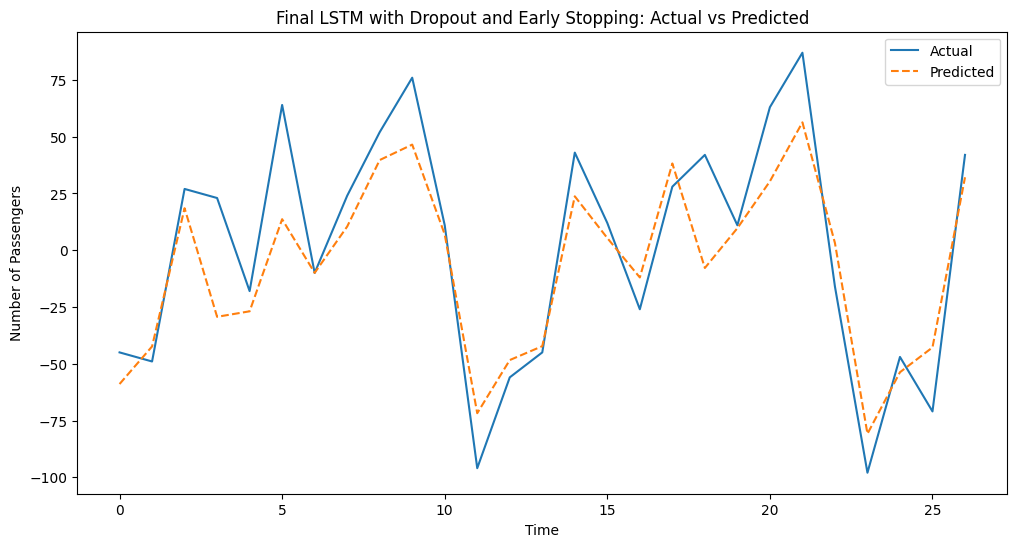

In [12]:
test_preds_actual = scaler.inverse_transform(test_preds.numpy())
y_test_actual = scaler.inverse_transform(y_test.numpy())

results["Final LSTM with Dropout and Early Stopping"] = {
    "train_losses": train_losses.copy(),
    "test_loss": test_loss.item(),
    "predictions": test_preds_actual.copy(),
}

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(test_preds_actual, label='Predicted', linestyle='--')
plt.title("Final LSTM with Dropout and Early Stopping: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()

## Comparing Experiments

                                        Model  Test Loss (MSE)
0                               Baseline LSTM         0.082146
1                LSTM with Larger Hidden Size         0.031879
2  Final LSTM with Dropout and Early Stopping         0.060095


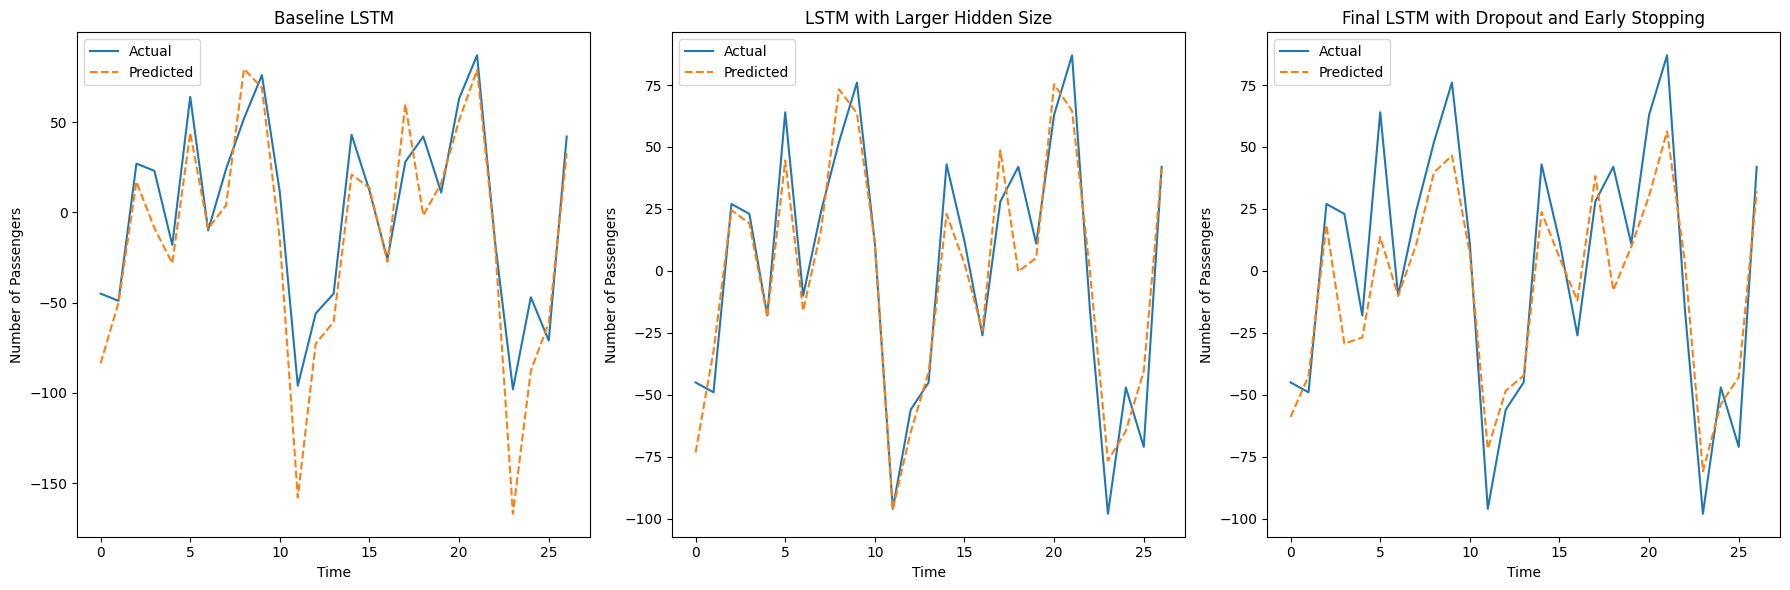

In [13]:
import pandas as pd

summary = pd.DataFrame({
    "Model": list(results.keys()),
    "Test Loss (MSE)": [results[model]["test_loss"] for model in results],
})

print(summary)

plt.figure(figsize=(18, 6))

for i, (model_name, result) in enumerate(results.items(), 1):
    plt.subplot(1, 3, i)
    plt.plot(y_test_actual, label='Actual')
    plt.plot(result["predictions"], label='Predicted', linestyle='--')
    plt.title(model_name)
    plt.xlabel("Time")
    plt.ylabel("Number of Passengers")
    plt.legend()

plt.tight_layout()
plt.show()